Copyright 2020 The TensorFlow Authors. All Rights Reserved.
Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Author : [jaeyoo@](https://github.com/jaeyoo), [khanhlvg@](https://github.com/khanhlvg), [abattery@](https://github.com/abattery), [thaink@](https://github.com/thaink) (Google Research) and [dathudeptrai@](https://github.com/dathudeptrai) (owner TensorflowTTS)

# TensorflowTTS Real-Time TFLite Conversion demonstration

This notebook provides a demo to convert models from TensorflowTTS to TFlite

- Github: https://github.com/TensorSpeech/TensorflowTTS
- Audio samples: https://tensorspeech.github.io/TensorflowTTS/

## Install

In [ ]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS
os.chdir("TensorFlowTTS")
!pip install  .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

Cloning into 'TensorFlowTTS'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 5140 (delta 2), reused 3 (delta 1), pack-reused 5127
Receiving objects: 100% (5140/5140), 81.49 MiB | 30.78 MiB/s, done.
Resolving deltas: 100% (3285/3285), done.
Processing /content/TensorFlowTTS
     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 184kB 50.3MB/s 
     |████████████████████████████████| 245kB 47.0MB/s 
     |████████████████████████████████| 225kB 46.6MB/s 
     |████████████████████████████████| 1.3MB 42.4MB/s 
     |████████████████████████████████| 1.7MB 41.1MB/s 
     |████████████████████████████████| 3.1MB 38.6MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 184kB 39.1MB/s 
  Created wheel for TensorFlowTTS: filename=TensorFlowTTS-0.0-cp36

In [ ]:
!pip install tensorflow-gpu==2.3.1

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.1'

## Download pretrained feature generation model

You can select one from two models. Please only run the seletected model cells.


In [ ]:
# tacotron2
print("Downloading Tacotron2 model...")
!gdown --id {"12jvEO1VqFo1ocrgY9GUHF_kVcLn3QaGW"} -O tacotron2-120k.h5
!gdown --id {"1OI86hkN1YCpHBsIKnkELNbSho5Pj-pPY"} -O tacotron2_config.yml

# FastSpeech
print("Downloading FastSpeech model...")
!gdown --id {"1T5GOE_M27zJlCAjnanpOS9HBPUcdE9sB"} -O fastspeech-150k.h5
!gdown --id {"1TnkL2-rIZ6N-n4z4oHp3X2wIpxiFwu2H"} -O fastspeech_config.yml

# FastSpeech2
print("Downloading FastSpeech2 model...")
!gdown --id {"1EhMD20uAFlKsii1lMnlkrsenVTFKM0ld"} -O fastspeech2-150k.h5
!gdown --id {"1wnbIgjTI2iUsCyVJ37ar9CS8-aEjVEee"} -O fastspeech2_config.yml

Downloading...
From: https://drive.google.com/uc?id=12jvEO1VqFo1ocrgY9GUHF_kVcLn3QaGW
To: /content/tacotron2-120k.h5
128MB [00:00, 148MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OI86hkN1YCpHBsIKnkELNbSho5Pj-pPY
To: /content/tacotron2_config.yml
100% 1.49k/1.49k [00:00<00:00, 2.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T5GOE_M27zJlCAjnanpOS9HBPUcdE9sB
To: /content/fastspeech-150k.h5
121MB [00:01, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1TnkL2-rIZ6N-n4z4oHp3X2wIpxiFwu2H
To: /content/fastspeech_config.yml
100% 1.51k/1.51k [00:00<00:00, 4.61MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EhMD20uAFlKsii1lMnlkrsenVTFKM0ld
To: /content/fastspeech2-150k.h5
125MB [00:00, 174MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1wnbIgjTI2iUsCyVJ37ar9CS8-aEjVEee
To: /content/fastspeech2_config.yml
100% 1.67k/1.67k [00:00<00:00, 3.26MB/s]


## Load Model

In [ ]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.processor import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import LJSPEECH_SYMBOLS

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
# Tacotron2
from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.models import TFTacotron2


with open('tacotron2_config.yml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

config = Tacotron2Config(**config["tacotron2_params"])
tacotron2 = TFTacotron2(config=config, enable_tflite_convertible=True, name="tacotron2v2")

# Newly added :
tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(1000) # be careful

tacotron2._build()
tacotron2.load_weights("tacotron2-120k.h5")

In [ ]:
# FastSpeech
from tensorflow_tts.configs import FastSpeechConfig
from tensorflow_tts.models import TFFastSpeech

with open('fastspeech_config.yml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

config = FastSpeechConfig(**config["fastspeech_params"])
fastspeech = TFFastSpeech(config=config, enable_tflite_convertible=True, name="fastspeech")
fastspeech._build()
fastspeech.load_weights("fastspeech-150k.h5")

In [ ]:
# FastSpeech2
from tensorflow_tts.configs import FastSpeech2Config
from tensorflow_tts.models import TFFastSpeech2

with open('fastspeech2_config.yml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

config = FastSpeech2Config(**config["fastspeech_params"])
fastspeech2 = TFFastSpeech2(config=config, enable_tflite_convertible=True, name="fastspeech2")
fastspeech2._build()
fastspeech2.load_weights("fastspeech2-150k.h5")

## Convert to TF Lite

### Tacotron-2

In [ ]:
# Concrete Function
tacotron2_concrete_function = tacotron2.inference_tflite.get_concrete_function()

In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [tacotron2_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with open('tacotron2.tflite', 'wb') as f:
  f.write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model size is 32.518265 MBs.


### FastSpeech

In [ ]:
# Concrete Function
fastspeech_concrete_function = fastspeech.inference_tflite.get_concrete_function()

In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [fastspeech_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with open('fastspeech_quant.tflite', 'wb') as f:
  f.write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model size is 28.296082 MBs.


### FastSpeech2

In [ ]:
# Concrete Function
fastspeech2_concrete_function = fastspeech2.inference_tflite.get_concrete_function()

In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [fastspeech2_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with open('fastspeech2_quant.tflite', 'wb') as f:
  f.write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model size is 29.278976 MBs.


# Inference

In [ ]:
def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

## Tacotron-2

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='tacotron2.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data.
def prepare_input(input_ids):
  return (tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
          tf.convert_to_tensor([len(input_ids)], tf.int32),
          tf.convert_to_tensor([0], dtype=tf.int32))
  
# Test the model on random input data.
def infer(input_text):
  processor = LJSpeechProcessor(None, symbols=LJSPEECH_SYMBOLS)
  input_ids = processor.text_to_sequence(input_text.lower())
  interpreter.resize_tensor_input(input_details[0]['index'], 
                                  [1, len(input_ids)])
  interpreter.allocate_tensors()
  input_data = prepare_input(input_ids)
  for i, detail in enumerate(input_details):
    print(detail)
    input_shape = detail['shape']
    interpreter.set_tensor(detail['index'], input_data[i])

  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  return (interpreter.get_tensor(output_details[0]['index']),
          interpreter.get_tensor(output_details[1]['index']))

In [ ]:
input_text = "Recent research at Harvard has shown meditating\
for as little as 8 weeks, can actually increase the grey matter in the \
parts of the brain responsible for emotional regulation, and learning."

decoder_output_tflite, mel_output_tflite = infer(input_text)

{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'input_lengths', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speaker_ids', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


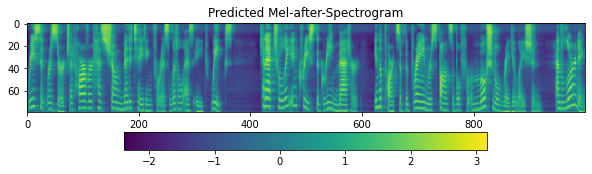

In [ ]:
visualize_mel_spectrogram(decoder_output_tflite)

## FastSpeech

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='fastspeech_quant.tflite')

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data.
def prepare_input(input_ids):
  input_ids = tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0)
  return (input_ids,
          tf.convert_to_tensor([0], tf.int32),
          tf.convert_to_tensor([1.0], dtype=tf.float32))

# Test the model on random input data.
def infer(input_text):
  for x in input_details:
    print(x)
  for x in output_details:
    print(x)
  processor = LJSpeechProcessor(None, symbols=LJSPEECH_SYMBOLS)
  input_ids = processor.text_to_sequence(input_text.lower())
  interpreter.resize_tensor_input(input_details[0]['index'], 
                                  [1, len(input_ids)])
  interpreter.resize_tensor_input(input_details[1]['index'], 
                                  [1])
  interpreter.resize_tensor_input(input_details[2]['index'], 
                                  [1])
  interpreter.allocate_tensors()
  input_data = prepare_input(input_ids)
  for i, detail in enumerate(input_details):
    input_shape = detail['shape']
    interpreter.set_tensor(detail['index'], input_data[i])

  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  return (interpreter.get_tensor(output_details[0]['index']),
          interpreter.get_tensor(output_details[1]['index']))

In [ ]:
input_text = "Recent research at Harvard has shown meditating\
for as little as 8 weeks, can actually increase the grey matter in the \
parts of the brain responsible for emotional regulation, and learning."

decoder_output_tflite, mel_output_tflite = infer(input_text)

{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speaker_ids', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speed_ratios', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'na

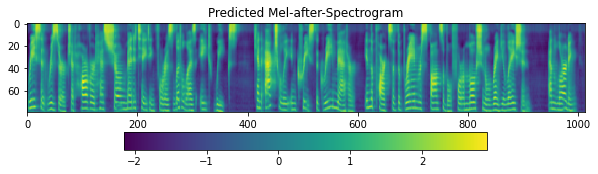

In [ ]:
visualize_mel_spectrogram(decoder_output_tflite)

## FastSpeech2

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='fastspeech2_quant.tflite')

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data.
def prepare_input(input_ids):
  input_ids = tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0)
  return (input_ids,
          tf.convert_to_tensor([0], tf.int32),
          tf.convert_to_tensor([1.0], dtype=tf.float32),
          tf.convert_to_tensor([1.0], dtype=tf.float32),
          tf.convert_to_tensor([1.0], dtype=tf.float32))

# Test the model on random input data.
def infer(input_text):
  for x in input_details:
    print(x)
  for x in output_details:
    print(x)
  processor = LJSpeechProcessor(None, symbols=LJSPEECH_SYMBOLS)
  input_ids = processor.text_to_sequence(input_text.lower())
  interpreter.resize_tensor_input(input_details[0]['index'], 
                                  [1, len(input_ids)])
  interpreter.resize_tensor_input(input_details[1]['index'], 
                                  [1])
  interpreter.resize_tensor_input(input_details[2]['index'], 
                                  [1])
  interpreter.resize_tensor_input(input_details[3]['index'], 
                                  [1])
  interpreter.resize_tensor_input(input_details[4]['index'], 
                                  [1])
  interpreter.allocate_tensors()
  input_data = prepare_input(input_ids)
  for i, detail in enumerate(input_details):
    input_shape = detail['shape']
    interpreter.set_tensor(detail['index'], input_data[i])

  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  return (interpreter.get_tensor(output_details[0]['index']),
          interpreter.get_tensor(output_details[1]['index']))

In [ ]:
input_text = "Recent research at Harvard has shown meditating\
for as little as 8 weeks, can actually increase the grey matter in the \
parts of the brain responsible for emotional regulation, and learning."

decoder_output_tflite, mel_output_tflite = infer(input_text)

{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speaker_ids', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speed_ratios', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'na

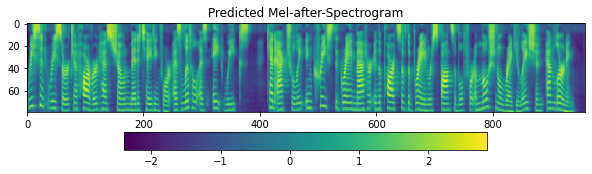

In [ ]:
visualize_mel_spectrogram(decoder_output_tflite)

# Disclaimer

- This colab doesn't care about the latency, so it compressed the model with quantization. 8 bit run on desktop will slow.

- The TFLite file doesn't have LJSpeechProcessor. So you need to run it before feeding input vectors.

- tensorflow-gpu==2.3.1